# **Agent 시스템 확장_Tools**

## **1.환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(LangGraph)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

In [2]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.2.*" wikipedia -q

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.2/457.2 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.7/153.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

#### 2) 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import os
import openai

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### (3) OpenAI API Key 확인

In [4]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/LangGraph/'

# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

In [5]:
print(os.environ['OPENAI_API_KEY'][:30])

sk-6HnpTor5FDdHd3WXGaRUshfzSdb


## 2.간단한 Chatbot Agent 만들기

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, AnyMessage

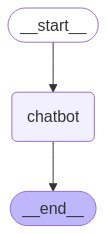

### (1) State 정의

LangGraph에서 LLM 메시지 히스토리를 자동으로 관리하기 위해 사용되는 특별한 필드 정의 방식

In [7]:
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 리스트에 메시지를 append

### (2) Node 정의

In [8]:
llm = ChatOpenAI(model="gpt-4.1-mini")  # 언어 모델을 gpt-4o로 설정

def chatbot(state: State):
    result = llm.invoke(state["messages"])
    return {"messages": result}   # 응답 "messages"에 넣어 반환

### (3) 그래프 정의

In [9]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("chatbot", chatbot)

# connect nodes
builder.set_entry_point("chatbot")      # "chatbot"는 START로 연결
builder.set_finish_point("chatbot")     # "chatbot"는 END로 연결

# builder.add_edge(START, "chatbot")
# builder.add_edge("chatbot", END)

# compile the graph
graph = builder.compile()

* 그래프 시각화

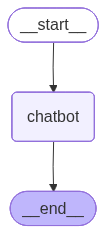

In [10]:
graph

### (4) Graph 실행

* 실행1

In [11]:
result = graph.invoke({"messages": [HumanMessage("안녕")]})

In [12]:
result

{'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='348d85d2-358a-4c5d-a92b-cebfb2b78ac6'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 9, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_376a7ccef1', 'id': 'chatcmpl-CrLvkCBFfa8iWXcU9VYBXYgubTZAZ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7ac31995-e862-426c-955c-758df5dbd8e3-0', usage_metadata={'input_tokens': 9, 'output_tokens': 11, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [13]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

안녕
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


> 메시지 객체(HumanMessage, AIMessage 등)는 LangChain에서 제공하는 특수 클래스.  
.pretty_print()는 그 메시지를 깔끔하고 보기 좋게 출력하는 함수

* [참조]실행2
    * input을 받아서
    * .stream(...)
        * LangGraph에서 .invoke()는 전체 실행 결과를 한 번에 반환
        * 반면 .stream()은 실행되는 중간 중간 결과를 이벤트처럼 출력할 수 있어! 상태를 점진적으로 업데이트하며 리얼타임 반응처럼 처리 가능
        * 여기서는 state = {"messages": ("user", user_input)}가 전달됨
        * 즉, 사용자 메시지를 상태로 넘김
    * value["messages"][-1].content
        * 각 event는 그래프 실행 도중 생성된 중간 상태들
        * 그 중 "messages" 키의 가장 마지막 메시지(content)를 출력
        * 즉, 에이전트의 최신 응답만 뽑아서 보여줌

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("잘가!")
        break
    for event in graph.stream({"messages": [HumanMessage(user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"].content)

User: 안녕? 나는 용인에 살아.
Assistant: 안녕하세요! 용인에 사신다니 반가워요. 용인에 대해 궁금한 점이나 이야기하고 싶은 것이 있나요? 무엇이든 말씀해 주세요!
User: 아니. 그게 아니라. 내일 날씨가 궁금해. 내일 몇일인지와 날씨 알려줘.
Assistant: 오늘 날짜가 2024년 4월 27일이므로, 내일은 2024년 4월 28일입니다.  
하지만 실시간 날씨 정보는 제공해 드릴 수 없어서, 내일 날씨는 기상청 웹사이트나 날씨 앱을 통해 확인해 보시는 것을 추천드립니다. 도움이 필요하면 언제든 말씀해 주세요!
User: q
잘가!


## 3.Tool 사용하기

In [14]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

### (1) Custom Tool 만들기

#### 1) Tool 준비하기

* langchain_core.tools의 tool을 import하면 @tool 데코레이터만으로 함수를 langchain의 tool로 변환 가능

In [15]:
@tool
def calculator_tool(expression: str) -> str:  # type hint : 함수의 출력 type은 str
    '''수식을 입력 받아 계산하는 도구'''  # docstring : 도구에 대한 간결한 설명 (to LLM)
    try:
        result = eval(expression)  # Python 내장 함수 eval()을 사용해서 문자열로 된 식을 계산
        return f"계산 결과: {result}"
    except Exception as e:
        return f"오류 발생: {str(e)}"

@tool
def get_weather(location: str):
    """현재 날씨 정보를 반환합니다."""
    # 입력된 지역이 "서울"인 경우에 해당하는 날씨 정보를 반환합니다.
    if location in ["서울"]:
        return "현재 온도는 20도이며 맑고 화창한 날씨입니다."
    else:
        # "서울"이 아닌 경우, 다른 날씨 정보를 반환합니다.
        return "현재 온도는 10도이며 조금 쌀쌀합니다."


#### 2) Tool 등록 및 ToolNode 생성

- tools 리스트: 정의된 tool 함수들을 리스트에 담습니다.
- ToolNode 인스턴스: 등록된 tools들을 관리하고 호출 요청을 처리하기 위해 ToolNode를 생성합니다.

In [16]:
#Tool Node로 묶어줄 때, 리스트 형태로 tool들을 함께 제공합니다.
tools = [get_weather, calculator_tool]
tool_node = ToolNode(tools)

In [17]:
#bind_tools() 함수로 LLM에게 어떤 tool들이 있는지 인지시켜 도구를 활용하도록 만듭니다.
from langchain_openai import ChatOpenAI

llm_with_tools = ChatOpenAI(model="gpt-4.1-mini", temperature=0
                              ).bind_tools(tools)

* tool 사용해보기

In [18]:
llm_with_tools.invoke("서울 날씨는 어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_dgPESkH2C4EesRtghvFM4WTM',
  'type': 'tool_call'}]

| 필드 | 의미 |
| ---- | ---- |
| name | 사용하려는 툴의 이름 → get_weather |
| args | 툴에 넘겨줄 인자(argument) → {"location": "서울"} |
| id | 호출 ID (LangGraph나 LangChain 내부 추적용) |
| type | "tool_call" → 이 응답은 도구 호출이라는 의미 |

In [19]:
llm_with_tools.invoke("오늘 점심은 뭐 먹을까?").tool_calls

[]

In [20]:
llm_with_tools.invoke("1+3*(20-15)").tool_calls

[{'name': 'calculator_tool',
  'args': {'expression': '1+3*(20-15)'},
  'id': 'call_5krYCswdRlQkF8yrNDEHttqZ',
  'type': 'tool_call'}]

In [21]:
tool_node.invoke({"messages": [llm_with_tools.invoke("1+3*(20-15)")]} ,
                  config={      "configurable": {"tools": tools}})

{'messages': [ToolMessage(content='계산 결과: 16', name='calculator_tool', tool_call_id='call_cVC4RC4M2n8NoLrd81MQWg7d')]}

In [22]:
tool_node.invoke({"messages": [llm_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content='현재 온도는 20도이며 맑고 화창한 날씨입니다.', name='get_weather', tool_call_id='call_Whl908mSI7JrZeJDcKFb5kEW')]}

#### 3) 그래프 만들기

* 그래프 흐름
    - 내장 툴들을 불러오기 (load_tools())
    - 하나의 ToolNode에 묶기
    - LangGraph로 LLM → ToolNode → LLM 구조 실행하기


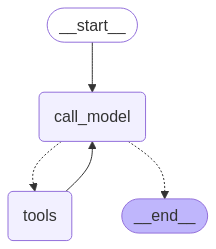

In [23]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph

* State

In [24]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [25]:
# 모델 호출 함수 (GPT 호출)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 조건 분기 함수: 툴 호출이 필요한가?
def should_continue(state: State) -> Literal["tools", END]:  # 출력은 반드시 "tools" 혹은 END 여야 함.
    messages = state["messages"]
    last_message = messages[-1]  # 가장 최근 message
    if last_message.tool_calls:
        return "tools"
    return END

* 그래프 구성

In [26]:
builder = StateGraph(State)

# 노드 추가
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# 연결
builder.set_entry_point("call_model")
builder.add_conditional_edges("call_model", should_continue,
                            #   {"tools": "tools", END: END}
                              )
builder.add_edge("tools", "call_model")  # 루프 연결

# 컴파일
graph = builder.compile()

* 그래프 시각화

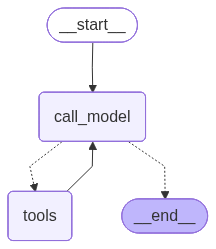

In [ ]:
graph

#### 4) 그래프 사용하기

In [27]:
final_state = graph.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

'서울은 현재 온도 20도에 맑고 화창한 날씨입니다. 다른 정보가 필요하시면 말씀해 주세요!'

In [28]:
# example with a multiple tool calls in succession

for chunk in graph.stream(
    {"messages": [("human", "2**8")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

2**8
================================== Ai Message ==================================
Tool Calls:
  calculator_tool (call_II9add5x2Ibamsh2WsXimrYG)
 Call ID: call_II9add5x2Ibamsh2WsXimrYG
  Args:
    expression: 2**8
================================= Tool Message =================================
Name: calculator_tool

계산 결과: 256
================================== Ai Message ==================================

2의 8제곱은 256입니다.


### (2) langchain 내장 tool 사용하기

#### 1) Tool 준비하기

* langchain_core.tools의 tool을 import하면 @tool 데코레이터만으로 함수를 langchain의 tool로 변환 가능

In [29]:
from langchain.agents import load_tools

llm = ChatOpenAI(model="gpt-4.1-mini")
tools = load_tools(["llm-math", "wikipedia"], llm=llm) # 일부 툴이 LLM을 내부적으로 쓸 때 필요한 설정


#### 2) ToolNode 생성

In [30]:
tool_node = ToolNode(tools)

In [31]:
# 툴을 쓸 수 있는 LLM
llm_with_tools = llm.bind_tools(tools)  # GPT가 이 툴들을 사용하겠다고 판단할 수 있게 도와주는 설정

#### 3) 그래프 만들기

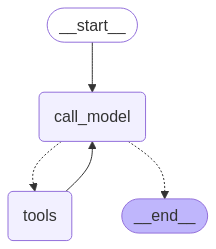

In [32]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph

* State

In [33]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [34]:
# 모델 호출 함수 (GPT 호출)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 조건 분기 함수: 툴 호출이 필요한가?
def should_continue(state: State) -> Literal["tools", END]:  # 출력은 반드시 "tools" 혹은 END 여야 함.
    messages = state["messages"]
    last_message = messages[-1]  # 가장 최근 message
    if last_message.tool_calls:
        return "tools"
    return END

* 그래프 구성

In [35]:
builder = StateGraph(State)

# 노드 추가
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# 연결
builder.set_entry_point("call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")  # 루프 연결

# 컴파일
graph = builder.compile()

* 그래프 시각화

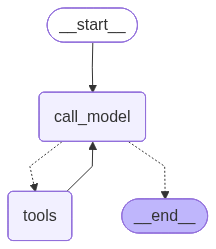

In [36]:
graph

#### 4) 그래프 사용하기

In [37]:
result = graph.invoke({
    "messages": [HumanMessage(content="피타고라스의 정리를 설명해줘")]
})

# 출력
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

피타고라스의 정리를 설명해줘
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_i4G26Nvb7vUKyfEPJZIALwzi)
 Call ID: call_i4G26Nvb7vUKyfEPJZIALwzi
  Args:
    query: 피타고라스의 정리
================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

피타고라스의 정리는 직각삼각형에서만 적용되는 수학 정리입니다. 이 정리에 따르면, 직각삼각형의 두 직각을 이루는 변(즉, 두 밑변과 높이)의 길이의 제곱을 합한 값은 빗변(직각을 마주 보는 가장 긴 변)의 길이의 제곱과 같다는 것을 의미합니다.

수식으로 표현하면 다음과 같습니다:
a² + b² = c²

여기서 a와 b는 직각을 이루는 두 변의 길이이고, c는 빗변의 길이입니다.

즉, 만약 한 직각삼각형에서 두 변의 길이를 알고 있을 때, 피타고라스의 정리를 사용하면 나머지 한 변의 길이를 쉽게 구할 수 있습니다.


In [38]:
result = graph.invoke({
    "messages": [HumanMessage(content="3의 제곱근은 얼마야?")]
})

# 출력
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

3의 제곱근은 얼마야?
================================== Ai Message ==================================
Tool Calls:
  Calculator (call_SQJrKLMK7IB7O3Vx2LUXaXeW)
 Call ID: call_SQJrKLMK7IB7O3Vx2LUXaXeW
  Args:
    __arg1: sqrt(3)
================================= Tool Message =================================
Name: Calculator

Answer: 1.7320508075688772
================================== Ai Message ==================================

3의 제곱근은 약 1.732입니다.


## 4.실습

### (1) 실습1

* LLM을 하나 생성하시오 (ChatOpenAI)
* 다음 도구 3개를 load_tools()를 사용하여 불러오고, ToolNode로 묶으시오
    * llm-math, wikipedia, serpapi
* GPT에게 도구 목록을 알려주기 위해 .bind_tools(tools)를 사용하시오
* 이를 위해 필요한 준비작업을 수행하시오.
    * serpapi api key를 받아 등록
    * 필요한 라이브러리 설치

In [39]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.tool_node import ToolNode
from langchain.agents import load_tools
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import Literal, Annotated
from typing_extensions import TypedDict
from langchain_core.tools import tool

#### 1) Tool 준비하기

In [40]:
!pip install google-search-results -q

  Preparing metadata (setup.py) ... done


In [41]:
from langchain.agents import load_tools

llm = ChatOpenAI(model="gpt-4.1-mini")
tools = load_tools(["llm-math", "wikipedia", "serpapi"], llm=llm) # 일부 툴이 LLM을 내부적으로 쓸 때 필요한 설정


#### 2) ToolNode 생성

In [42]:
tool_node = ToolNode(tools)

In [43]:
# 툴을 쓸 수 있는 LLM
llm_with_tools = llm.bind_tools(tools)  # GPT가 이 툴들을 사용하겠다고 판단할 수 있게 도와주는 설정

#### 3) 그래프 만들기

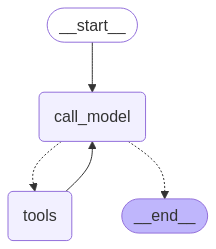

* State

In [44]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [45]:
# 모델 호출 함수 (GPT 호출)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 조건 분기 함수: 툴 호출이 필요한가?
def should_continue(state: State) -> Literal["tools", END]:  # 출력은 반드시 "tools" 혹은 END 여야 함.
    messages = state["messages"]
    last_message = messages[-1]  # 가장 최근 message
    if last_message.tool_calls:
        return "tools"
    return END

* 그래프 구성

In [46]:
builder = StateGraph(State)

# 노드 추가
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# 연결
builder.set_entry_point("call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")  # 루프 연결

# 컴파일
graph = builder.compile()

* 그래프 시각화

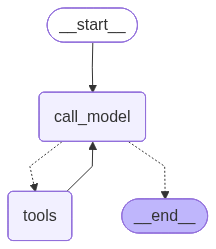

In [47]:
graph

#### 4) 그래프 사용하기

In [48]:
result = graph.invoke({
    "messages": [HumanMessage(content="유로 2024 우승팀은?")]
})

# 출력
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

유로 2024 우승팀은?
================================== Ai Message ==================================
Tool Calls:
  Search (call_Ch9hTu3c4AbyMtJwz84uszxS)
 Call ID: call_Ch9hTu3c4AbyMtJwz84uszxS
  Args:
    __arg1: Euro 2024 winner
================================= Tool Message =================================
Name: Search

Spain national football team
================================== Ai Message ==================================

2024년 유럽 축구 선수권 대회(유로 2024)는 아직 진행 중이거나 결과가 확정되지 않았기 때문에 우승팀에 대한 정확한 정보를 제공할 수 없습니다. 대회 결과가 발표되면 알려드릴 수 있습니다. 다른 궁금한 점이 있으면 말씀해 주세요!


In [49]:
result = graph.invoke({
    "messages": [HumanMessage(content="deep seek가 주목받은 점은 무엇때문이야?")]
})

# 출력
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

deep seek가 주목받은 점은 무엇때문이야?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_4sHlMbEwIPY98NfFjXhQYlxm)
 Call ID: call_4sHlMbEwIPY98NfFjXhQYlxm
  Args:
    query: Deep Seek
================================= Tool Message =================================
Name: wikipedia

Page: DeepSeek
Summary: Hangzhou DeepSeek Artificial Intelligence Basic Technology Research Co., Ltd., doing business as DeepSeek, is a Chinese artificial intelligence (AI) company that develops large language models (LLMs). Based in Hangzhou, Zhejiang, DeepSeek is owned and funded by the Chinese hedge fund High-Flyer. DeepSeek was founded in July 2023 by Liang Wenfeng, the co-founder of High-Flyer, who also serves as the CEO for both of the companies. The company launched an eponymous chatbot alongside its DeepSeek-R1 model in January 2025.
Released under the MIT License, DeepSee

### (3) 실습2

* 날씨 기반 의상 추천 에이전트
    * 지역 날씨 정보를 조회한 뒤
    * 해당 날씨에 맞는 옷차림을 추천하는
    * Tool 사용 기반 LangChain Agent
* 요구사항
    * get_weather 툴 정의 : 서울, 부산, 제주 중 입력받은 지역의 날씨 정보 반환
    * recommend_clothing 툴 정의 : 전달받은 날씨 정보(문자열)를 기반으로 옷차림 추천
    * 두 툴을 등록하여 에이전트 생성

* 사용자 질문 : "서울 날씨에 맞는 옷차림 추천해줘"
를 넣었을 때 → 날씨 툴 호출 → 옷 추천 툴 호출 → 답변

#### 1) Tool 준비하기

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
from langchain.tools import tool

@tool
def get_weather(location: str) -> str:
    """입력한 지역에 대한 고정된 날씨 정보를 반환합니다."""
    weather_db = {
        "서울": "흐림, 9도",
        "부산": "맑음, 18도",
        "제주": "비, 16도"
    }
    return weather_db.get(location, "날씨 정보를 찾을 수 없습니다.")

@tool
def recommend_clothing(weather: str) -> str:
    """날씨 정보를 기반으로 의상을 추천합니다."""
    if "흐림" in weather:
        return "긴팔과 가벼운 외투를 추천합니다."
    elif "맑음" in weather:
        return "반팔과 청바지를 추천합니다."
    elif "비" in weather:
        return "우산과 방수 재킷을 챙기세요."
    else:
        return "기본적인 외출 복장을 추천합니다."



#### 2) ToolNode 생성

In [ ]:
# 3. 툴과 LLM 연결
tools = [get_weather, recommend_clothing]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

#### 3) 그래프 만들기

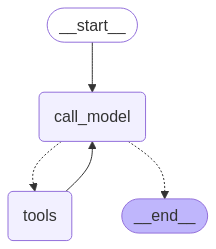

* State

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [ ]:
# 4. 모델 호출 노드
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}

# 5. 조건 분기 함수: 툴 호출 여부 판단
def should_continue(state: State) -> Literal["tools", END]:
    messages = state["messages"]
    last = messages[-1]
    if last.tool_calls:
        return "tools"
    return END

* 그래프 구성

In [ ]:
# 6. 그래프 구성
builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.set_entry_point("call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")

graph = builder.compile()

* 그래프 시각화

In [ ]:
graph

#### 4) 그래프 사용하기

In [ ]:
from langchain.schema import SystemMessage, HumanMessage

# 메시지 입력
inputs = {
    "messages": [
        SystemMessage(content="당신은 날씨에 따라 옷차림을 추천해주는 비서입니다."),
        HumanMessage(content="서울 날씨에 맞는 옷차림을 추천해줘")
    ]
}

result = graph.invoke(inputs)
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

당신은 날씨에 따라 옷차림을 추천해주는 비서입니다.
================================ Human Message =================================

서울 날씨에 맞는 옷차림을 추천해줘
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_5GyMg3FOnaqslae6unGuLZDY)
 Call ID: call_5GyMg3FOnaqslae6unGuLZDY
  Args:
    location: 서울
================================= Tool Message =================================
Name: get_weather

흐림, 9도
================================== Ai Message ==================================
Tool Calls:
  recommend_clothing (call_FMU5cphcEKgFU4Zb71nzT9iZ)
 Call ID: call_FMU5cphcEKgFU4Zb71nzT9iZ
  Args:
    weather: 흐림, 9도
================================= Tool Message =================================
Name: recommend_clothing

긴팔과 가벼운 외투를 추천합니다.
================================== Ai Message ==================================

오늘 서울은 흐리고 기온이 9도이므로 긴팔과 가벼운 외투를 입으시는 것을 추천합니다.


In [ ]:
inputs = {
    "messages": [
        SystemMessage(content="당신은 날씨에 따라 옷차림을 추천해주는 비서입니다."),
        HumanMessage(content="광주 날씨에 맞는 옷차림을 추천해줘")
    ]
}

result = graph.invoke(inputs)
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

당신은 날씨에 따라 옷차림을 추천해주는 비서입니다.
================================ Human Message =================================

광주 날씨에 맞는 옷차림을 추천해줘
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_4YcUXSQyxNDEuBMixTMpwGMY)
 Call ID: call_4YcUXSQyxNDEuBMixTMpwGMY
  Args:
    location: 광주
================================= Tool Message =================================
Name: get_weather

날씨 정보를 찾을 수 없습니다.
================================== Ai Message ==================================

현재 날씨 정보를 가져올 수 없어, 일반적인 광주의 계절별 날씨에 기반한 옷차림을 추천해드릴 수 있습니다. 혹시 계절을 말씀해 주실 수 있나요? 예를 들어 봄, 여름, 가을, 겨울 중 하나를 선택해 주세요.
